In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
pbp = pd.DataFrame()
for year in range(1999, 2021):
    i_df = pd.read_csv(f'pbp_data/play_by_play_{year}.csv.gz', compression='gzip', low_memory=False)
    pbp = pd.concat([pbp, i_df])

,season,cpoe,epa,play_id
0,2006,0.128113,-0.026475,1075
1,2007,-0.284450,-0.047064,1102
2,2008,1.020330,0.028465,1049
3,2009,-0.375394,-0.022921,1171
4,2010,0.433336,-0.036210,1195
5,2011,1.938222,0.060125,1243
6,2012,1.311710,0.079258,1238
7,2013,1.532594,0.102128,1317
8,2014,0.166423,0.040281,1272
9,2015,0.652693,0.051330,1232


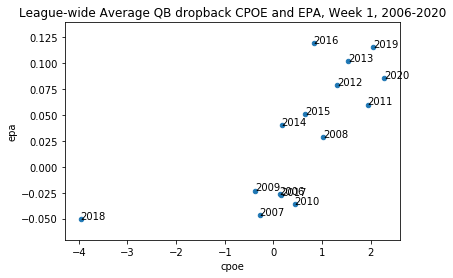

In [3]:
week_ones = pbp.loc[(pbp.week==1) & (pbp.season>=2006) & (pbp.qb_dropback==1)].groupby('season', as_index=False).agg({'cpoe':'mean', 'epa':'mean', 'play_id':'count'})
ax = week_ones.plot.scatter('cpoe', 'epa')
for i, season in enumerate(week_ones['season']):
        ax.annotate(season, (week_ones.cpoe.iloc[i], week_ones.epa.iloc[i]))
ax.set(title = 'League-wide Average QB dropback CPOE and EPA, Week 1, 2006-2020')
week_ones

In [4]:
prior_split = [1]
post_split = list(range(2,18))
backtest_pbp = pbp.loc[pbp.season<2020]
teams = backtest_pbp.loc[backtest_pbp.week.isin(prior_split)].groupby(['season', 'posteam']).agg({'epa':'mean', 'vegas_wp':'mean'}).rename(columns={'epa':'pre_off_epa', 'vegas_wp':'pre_mean_wp'})
teams['pre_def_epa'] = backtest_pbp.loc[backtest_pbp.week.isin(prior_split)].groupby(['season', 'defteam']).agg({'epa':'mean'})
teams['pre_net_epa'] = teams['pre_off_epa']-teams['pre_def_epa']
teams['post_off_epa'] = backtest_pbp.loc[backtest_pbp.week.isin(post_split)].groupby(['season', 'posteam']).agg({'epa':'mean'})
teams['post_mean_wp'] = backtest_pbp.loc[backtest_pbp.week.isin(post_split)].groupby(['season', 'posteam']).agg({'vegas_wp':'mean'})
teams['post_def_epa'] = backtest_pbp.loc[backtest_pbp.week.isin(post_split)].groupby(['season', 'defteam']).agg({'epa':'mean'})
teams['post_net_epa'] = teams['post_off_epa']-teams['post_def_epa']
corrs = teams.corr()**2

R^2: 0.2310946510038723


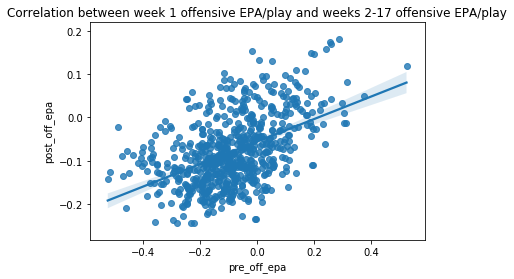

In [5]:
print(f'R^2: {corrs.loc["pre_off_epa", "post_off_epa"]}')
ax = sns.regplot(x='pre_off_epa', y='post_off_epa', data=teams)
t = ax.set(title="Correlation between week 1 offensive EPA/play and weeks 2-17 offensive EPA/play")

R^2: 0.17874695725459083


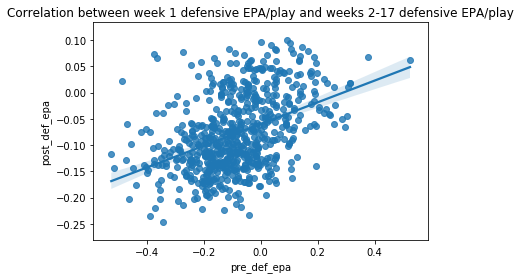

In [6]:
print(f'R^2: {corrs.loc["pre_def_epa", "post_def_epa"]}')
ax = sns.regplot(x='pre_def_epa', y='post_def_epa', data=teams)
t = ax.set(title="Correlation between week 1 defensive EPA/play and weeks 2-17 defensive EPA/play")

R^2: 0.05862193872032386


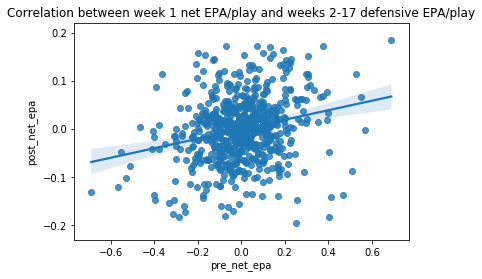

In [7]:
print(f'R^2: {corrs.loc["pre_net_epa", "post_net_epa"]}')
ax = sns.regplot(x='pre_net_epa', y='post_net_epa', data=teams)
t = ax.set(title="Correlation between week 1 net EPA/play and weeks 2-17 defensive EPA/play")

R^2: 0.14251566663516385


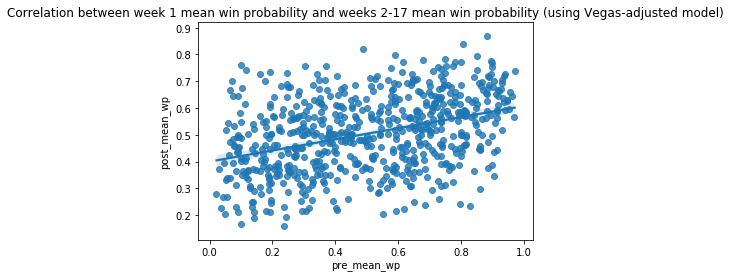

In [8]:
print(f'R^2: {corrs.loc["pre_mean_wp", "post_mean_wp"]}')
ax = sns.regplot(x='pre_mean_wp', y='post_mean_wp', data=teams)
t = ax.set(title="Correlation between week 1 mean win probability and weeks 2-17 mean win probability (using Vegas-adjusted model)")

In [9]:
def intraseason_split(prior_split, post_split, up_to_week=0):
    teams = backtest_pbp.loc[backtest_pbp.week.isin(prior_split)].groupby(['season', 'posteam']).agg({'epa':'mean', 'vegas_wp':'mean'}).rename(columns={'epa':'pre_off_epa', 'vegas_wp':'pre_mean_wp'})
    teams['pre_def_epa'] = backtest_pbp.loc[backtest_pbp.week.isin(prior_split)].groupby(['season', 'defteam']).agg({'epa':'mean'})
    teams['pre_net_epa'] = teams['pre_off_epa']-teams['pre_def_epa']
    teams['post_off_epa'] = backtest_pbp.loc[backtest_pbp.week.isin(post_split)].groupby(['season', 'posteam']).agg({'epa':'mean'})
    teams['post_mean_wp'] = backtest_pbp.loc[backtest_pbp.week.isin(post_split)].groupby(['season', 'posteam']).agg({'vegas_wp':'mean'})
    teams['post_def_epa'] = backtest_pbp.loc[backtest_pbp.week.isin(post_split)].groupby(['season', 'defteam']).agg({'epa':'mean'})
    teams['post_net_epa'] = teams['post_off_epa']-teams['post_def_epa']
    teams['full_off_epa'] = backtest_pbp.groupby(['season', 'posteam']).agg({'epa':'mean'})
    teams['full_mean_wp'] = backtest_pbp.groupby(['season', 'posteam']).agg({'vegas_wp':'mean'})
    teams['full_def_epa'] = backtest_pbp.groupby(['season', 'defteam']).agg({'epa':'mean'})
    teams['full_net_epa'] = teams['full_off_epa']-teams['full_def_epa']
    corrs = teams.corr()**2
    if up_to_week!=0:
        corrs['up_to_week'] = up_to_week
    return corrs

corrs = []
for week in range(1,17):
    prior_split = list(range(1,week+1))
    post_split = list(range(week+1, 18))
    corrs.append(intraseason_split(prior_split, post_split, up_to_week=week))

In [10]:
def get_pred_remainder(series):
    try:
        return series.loc[f'post_{series.name.strip("pre_")}']
    except KeyError:
        return np.nan
def get_pred_full(series):
    try:
        return series.loc[f'full_{series.name.strip("pre_")}']
    except KeyError:
        return np.nan
corrs_df = pd.concat(corrs)
off_epa_pred = corrs_df.groupby('up_to_week', as_index=False).agg({'pre_off_epa':[get_pred_remainder, get_pred_full]})
def_epa_pred = corrs_df.groupby('up_to_week', as_index=False).agg({'pre_def_epa':[get_pred_remainder, get_pred_full]})
net_epa_pred = corrs_df.groupby('up_to_week', as_index=False).agg({'pre_net_epa':[get_pred_remainder, get_pred_full]})

off_epa_pred.columns = ['up to week', 'R^2 - rest of season', 'R^2 - full season']
def_epa_pred.columns = ['up to week', 'R^2 - rest of season', 'R^2 - full season']
net_epa_pred.columns = ['up to week', 'R^2 - rest of season', 'R^2 - full season']

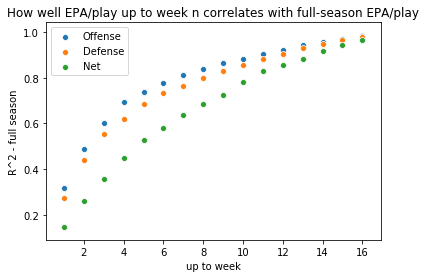

In [11]:
ax = sns.scatterplot(x='up to week', y='R^2 - full season', data=off_epa_pred)
sns.scatterplot(x='up to week', y='R^2 - full season', data=def_epa_pred)
sns.scatterplot(x='up to week', y='R^2 - full season', data=net_epa_pred)
ax.set(title="How well EPA/play up to week n correlates with full-season EPA/play")
ax.legend(['Offense', 'Defense', 'Net'])

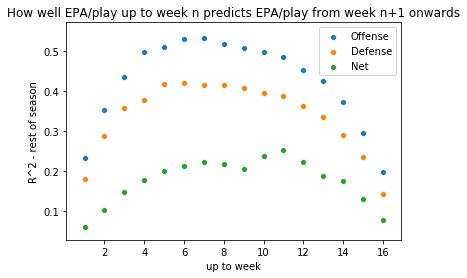

In [12]:
ax = sns.scatterplot(x='up to week', y='R^2 - rest of season', data=off_epa_pred)
sns.scatterplot(x='up to week', y='R^2 - rest of season', data=def_epa_pred)
sns.scatterplot(x='up to week', y='R^2 - rest of season', data=net_epa_pred)
ax.set(title="How well EPA/play up to week n predicts EPA/play from week n+1 onwards")
ax.legend(['Offense', 'Defense', 'Net'])

In [13]:
# columns: the data for which you want to find correlations and YoY stability
# groupby: the (single) variable by which you'd like to group by
# data: dataframe for which correlations/YoY stability are being found.
#       must contain all columns specified in first arg, as well as specified 
#       groupby col and 'season' col 
def year_to_year_corr(columns, groupby, data):
    cols = [groupby, 'season'] + columns 
    data = data[cols]
    ldata = data.groupby(by=groupby).shift(-1)
    data.columns = [groupby, 'prev_season'] + [f'prev_{col}' for col in columns]
    new_data = pd.concat((data, ldata), axis=1).dropna(subset=['season']).drop(columns=['prev_season','season'])
    tot_corr = new_data.corr(method='pearson')
    num_corr_cols = len(columns)
    corr = tot_corr.iloc[num_corr_cols:,num_corr_cols:]
    pred = tot_corr.iloc[0:num_corr_cols, num_corr_cols:]
    return corr,pred